In [68]:
import pandas as pd
import numpy as np
import json
import zipfile
import os
import math
from collections import Counter
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

#### CHANGE THE VALUES IN THE CELL BELOW
##### It should correspond to the amount of .json files you want to read and the filepath were your archive.zip folder is that you downloaded from kaggle at the following link (https://www.kaggle.com/datasets/himanshuwagh/spotify-million/data)
##### **DO NOT EXCTRACT THE DATA, THE SCRIPT READS DIRECTLY FROM THE ZIP FOLDER**

In [2]:
#CHANGE THE VALUES HERE

amount_of_json_files_to_read = 3
zip_path = "C:/Users/Clara/Downloads/archive.zip"
os.chdir("C:/Users/Clara/Downloads")

In [3]:
with open('spotify-million-metadata.json', 'r') as f:
    data = json.load(f)

In [4]:
playlist_rows = []
track_rows = []
file_rows = []


In [5]:
with zipfile.ZipFile(zip_path, 'r') as z:
    json_files = [f for f in z.namelist() if f.startswith("data/") and f.endswith(".json")]
    json_files.sort()
    
    for filename in json_files[:amount_of_json_files_to_read]:
        print(f"Reading {filename}...")
        with z.open(filename) as f:
            parsed = json.loads(f.read().decode("utf-8"))
            
            #metadata for file
            info = parsed.get("info", {})
            file_rows.append({
                "filename": filename,
                **info
            })
            
            #metadata playlist
            for pl in parsed["playlists"]:
                unique_artists = len({t["artist_name"] for t in pl["tracks"]})
                playlist_entry = {**pl}
                playlist_entry["num_artists"] = unique_artists
                playlist_entry["filename"] = filename
                playlist_rows.append(playlist_entry)
                
                #track metadata
                for track in pl["tracks"]:
                    track_entry = {**track}
                    track_entry["pid"] = pl.get("pid")
                    track_entry["filename"] = filename
                    track_rows.append(track_entry)


Reading data/mpd.slice.0-999.json...
Reading data/mpd.slice.1000-1999.json...
Reading data/mpd.slice.10000-10999.json...


In [6]:
df_playlists = pd.DataFrame(playlist_rows)
df_tracks = pd.DataFrame(track_rows)
df_files = pd.DataFrame(file_rows)

In [27]:
#df_full = df_tracks_playlists.merge(df_files, on="filename")
df_full= df_playlists.drop(columns = ["tracks"]).merge(df_tracks, on=["pid", "filename"], suffixes=("_playlist", "_track"))

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms_playlist,num_artists,filename,description,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms_track,album_name
0,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,data/mpd.slice.0-999.json,NaN,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook
1,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,data/mpd.slice.0-999.json,NaN,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone
2,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,data/mpd.slice.0-999.json,NaN,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit)
3,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,data/mpd.slice.0-999.json,NaN,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified
4,Throwbacks,false,0,1493424000,52,47,1,6,11532414,37,data/mpd.slice.0-999.json,NaN,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot


In [31]:
print(df_full.shape[0] == df_playlists["num_tracks"].sum()) #dq OK

True


In [97]:
df_full.loc[df_full["pid"] == 10815].to_excel("pid10815.xlsx") #check data integrity in Excel

<ipython-input-97-9d6774fb22fd>:1: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  df_full.loc[df_full["pid"] == 10815].to_excel("pid10815.xlsx") #check data integrity in Excel


In [25]:
# ---------- Utility functions ----------

def safe_nunique(s: pd.Series) -> int:
    return int(s.dropna().nunique()) if s is not None else 0

def entropy_from_counts(counts):
    if not counts:
        return 0.0
    freqs = np.array(counts, dtype=float)
    probs = freqs / freqs.sum()
    probs = probs[probs > 0]
    ent = -np.sum(probs * np.log2(probs))
    max_ent = math.log2(len(probs)) if len(probs) > 1 else 1.0
    return float(ent / max_ent) if max_ent > 0 else 0.0

def top_k_from_series(s: pd.Series, k: int = 5):
    if s is None:
        return []
    vc = s.dropna().value_counts().head(k)
    return list(zip(vc.index.tolist(), vc.tolist()))

def repr_col(group: pd.DataFrame, col: str, default=None):
    if col in group.columns:
        vals = group[col].dropna().unique()
        return vals[0] if len(vals) > 0 else default
    return default


# ---------- Main aggregation function ----------
def compute_playlist_aggregates(df_full: pd.DataFrame):
    """
    Returns:
      - df_agg: one row per playlist with all duration metrics in MILLISECONDS and MINUTES (for readability)
      - extras: dict with top artists and top tracks per playlist
    """

    required_cols = [
        'pid', 'artist_uri', 'album_uri', 'track_uri', 'duration_ms_track'
    ]
    missing = [c for c in required_cols if c not in df_full.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    g = df_full.groupby('pid', as_index=False)

    agg_rows = []
    extras = {'top_artists': {}, 'top_tracks': {}}

    for pid, group in g:
        row = {}

        # ---------- Identifiers ----------
        row['pid'] = pid
        row['playlist_name'] = repr_col(group, 'name')
        #row['description'] = repr_col(group, 'description') #not super relevant here, most people don't put a description

        # ---------- Own Counts ----------
        #row['num_tracks_actual'] = int(group.shape[0]) #doesn't work, to be investigateed 
        row['num_unique_tracks'] = safe_nunique(group['track_uri'])
        row['num_unique_artists'] = safe_nunique(group['artist_uri'])
        row['num_unique_albums'] = safe_nunique(group['album_uri'])
        
        # ---------- Playlist-level metadata ----------
        row['num_tracks_reported'] = int(repr_col(group, 'num_tracks', 0))
        row['num_albums_reported'] = int(repr_col(group, 'num_albums', 0))
        row['num_artists_reported'] = int(repr_col(group, 'num_artists', 0))
        row['num_followers'] = int(repr_col(group, 'num_followers', 0))
        row['num_edits'] = int(repr_col(group, 'num_edits', 0))
        #row['collaborative'] = bool(repr_col(group, 'collaborative', False)) collaborative is not stored as a boolean
        # Get the value as string first (or default "false")
        collab_str = str(repr_col(group, 'collaborative', 'false')).lower()
        # Convert to boolean
        row['collaborative'] = collab_str == 'true'
        row['modified_at'] = repr_col(group, 'modified_at')

        # ---------- DURATIONS (IN MINUTES) ----------
        total_ms = group['duration_ms_track'].sum(skipna=True)
        mean_ms = group['duration_ms_track'].mean(skipna=True)
        median_ms = group['duration_ms_track'].median(skipna=True)
        
        row['total_duration_tracks_ms'] = int(group['duration_ms_track'].sum(skipna=True))
        row['mean_track_duration_ms'] = float(group['duration_ms_track'].mean(skipna=True))
        row['median_track_duration_ms'] = float(group['duration_ms_track'].median(skipna=True))
        row['duration_ms_playlist_reported'] = int(
            repr_col(group, 'duration_ms_playlist', 0)
        )

        
       
        row['total_duration_tracks_min'] = float(total_ms / 60000.0)
        row['mean_track_duration_min'] = float(mean_ms / 60000.0)
        row['median_track_duration_min'] = float(median_ms / 60000.0)

        row['duration_playlist_reported_min'] = float(
            repr_col(group, 'duration_ms_playlist', 0) / 60000.0
        )

        # ---------- Structural ratios ----------
        row['artists_per_track'] = row['num_unique_artists'] / max(1, row['num_unique_tracks'])
        row['albums_per_track'] = row['num_unique_albums'] / max(1, row['num_unique_tracks'])
        row['tracks_per_artist'] = row['num_unique_tracks'] / max(1, row['num_unique_artists'])

        # ---------- Duplicate analysis ----------
        track_vc = group['track_uri'].dropna().value_counts()
        dup_occ = track_vc[track_vc > 1].sum()
        row['num_duplicate_track_occurrences'] = int(dup_occ)
#         row['fraction_duplicate_occurrences'] = float(
#             dup_occ / row['num_tracks_actual']
#         )

        # ---------- Diversity (entropy) ----------
        artist_counts = group['artist_uri'].dropna().value_counts().tolist()
        album_counts = group['album_uri'].dropna().value_counts().tolist()

        row['artist_entropy'] = entropy_from_counts(artist_counts)
        row['album_entropy'] = entropy_from_counts(album_counts)

        # ---------- Top contributors ----------
        extras['top_artists'][pid] = top_k_from_series(group['artist_name'], k=5)
        extras['top_tracks'][pid] = top_k_from_series(group['track_name'], k=5)

        # ---------- Dataset provenance ----------
        row['filename'] = repr_col(group, 'filename')
        row['slice'] = repr_col(group, 'slice')
        row['version'] = repr_col(group, 'version')
        row['generated_on'] = repr_col(group, 'generated_on')

        # ---------- Duration consistency check (IN MINUTES) ----------
        row['duration_delta_min'] = (
            row['total_duration_tracks_min'] -
            row['duration_playlist_reported_min']
        )

        agg_rows.append(row)

    df_agg = pd.DataFrame(agg_rows).set_index('pid').sort_index()

    return df_agg, extras


# ---------- Example usage ----------
# df_agg, extras = compute_playlist_aggregates(df_full)
# df_agg.to_parquet("playlist_level_aggregates.parquet")


# Entropy 

    In the above aggregration, we use entropy as a measure of diversity, unpredictability or evenness in a distribution.

    For each playlist, we count how many times each artist (or album) appears. From these counts, we compute how evenly the tracks are distributed across artists/albums. 

    If one artist dominates --> entropy is low (near or equal to 0 if a single artist is in the playlist) 
    If all artists appear equally often --> entropy is high (near or equal to 1 if all the artists are different)

    This gives a normalized diversity score between 0 and 1. 

# Top k from series 

    This function finds the top-k most frequent values in a column (e.g top artists, or top tracks in a playlist) and it returns a list of (value, count) pairs

# Repr_col 

    When grouping by playlist, many playlist-level columns (name, description, followers, etc.) are repeated on every track row.
    This function extracts one representative value from the group.

    How it works

    - It checks the column exists.

    - It drops NaNs and collects the unique values.

    - It returns the first unique value.

    - If there is no usable value, it returns the default.

    **Why it’s useful**

    It safely extracts one clean playlist-level attribute when your dataset repeats the same value on every track.



In [40]:
df_agg, extras = compute_playlist_aggregates(df_full)
#df_agg.to_excel("playlist_aggregates.xlsx")


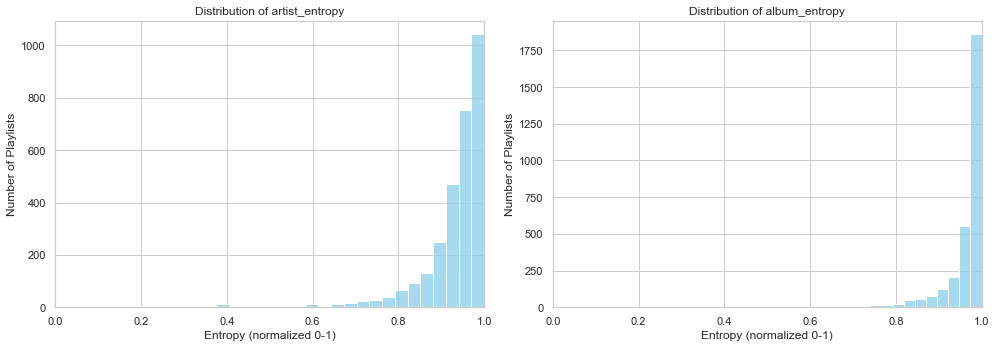

In [41]:
sns.set(style="whitegrid")

entropy_cols = ['artist_entropy', 'album_entropy']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col in zip(axes, entropy_cols):
    sns.histplot(df_agg[col], bins=30, ax=ax, color='skyblue')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Entropy (normalized 0-1)')
    ax.set_ylabel('Number of Playlists')
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()

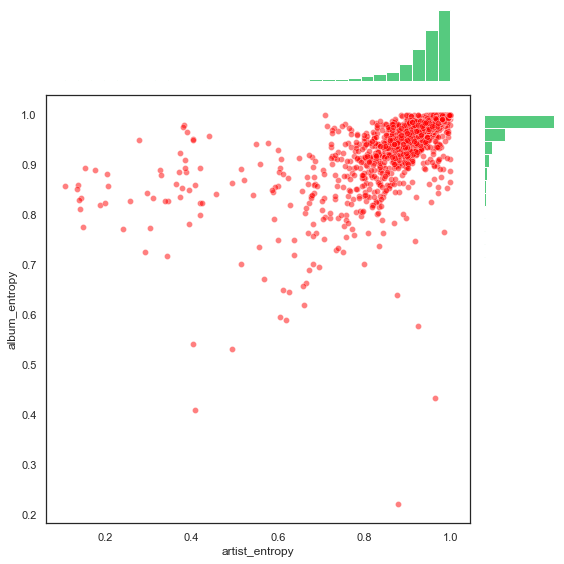

In [54]:

# Turn OFF grid globally
sns.set(style="white", rc={"axes.grid": False})

g = sns.jointplot(
    data=df_agg,
    x="artist_entropy",
    y="album_entropy",
    kind="scatter",
    color="red",
    alpha=0.5,
    marginal_kws=dict(bins=30, fill=True, color="#1DB954"),
    height=8
)

# Keep spines for joint plot (scatter)
joint_ax = g.ax_joint

for spine in ["top", "right", "left", "bottom"]:
    joint_ax.spines[spine].set_visible(True)

# Remove spines for marginal plots only
for ax in [g.ax_marg_x, g.ax_marg_y]:
    for spine in ["top", "right", "left", "bottom"]:
        ax.spines[spine].set_visible(False)

plt.show()

**First observations**

From the above, we can already observe that artist and album entropy is high in the extracted dataset, suggesting that playlists contain tracks from a wide variety of artists and albums in most cases. 

# Investigate Extras data

In [60]:
extras['top_artists'][0]

[('Jesse McCartney', 4),
 ('Chris Brown', 3),
 ('Justin Bieber', 3),
 ('Ne-Yo', 2),
 ('Beyoncé', 2)]

In [66]:
# Flatten top_artists into a long table
records = []
for pid, artist_list in extras['top_artists'].items():
    for rank, (artist_name, count) in enumerate(artist_list, start=1):
        records.append({
            "pid": pid,
            "artist_name": artist_name,
            "count_in_playlist": count,
            "rank_in_playlist": rank
        })
df_top_artists = pd.DataFrame(records)

**Investigate artist-artist co-occurence**

In [69]:
pair_counts = Counter()

for pid, group in df_top_artists.groupby("pid"):
    artists = sorted(set(group["artist_name"].dropna()))
    for a, b in combinations(artists, 2):
        pair_counts[(a, b)] += 1

df_artist_pairs = (
    pd.DataFrame(
        [
            {"artist_a": a, "artist_b": b, "num_playlists_together": cnt}
            for (a, b), cnt in pair_counts.items()
        ]
    )
    .sort_values("num_playlists_together", ascending=False)
)

In [78]:
df_artist_pairs

,artist_a,artist_b,num_playlists_together
593,Drake,Kanye West,51
594,Drake,Kendrick Lamar,46
3137,Drake,Future,39
2035,Drake,The Weeknd,33
1174,Drake,Rihanna,31
...,...,...,...
8981,James Blake,Janelle Monáe,1
8980,Dj Bitman,Trüby Trio,1
8979,Dj Bitman,Janelle Monáe,1
8978,Dj Bitman,James Blake,1


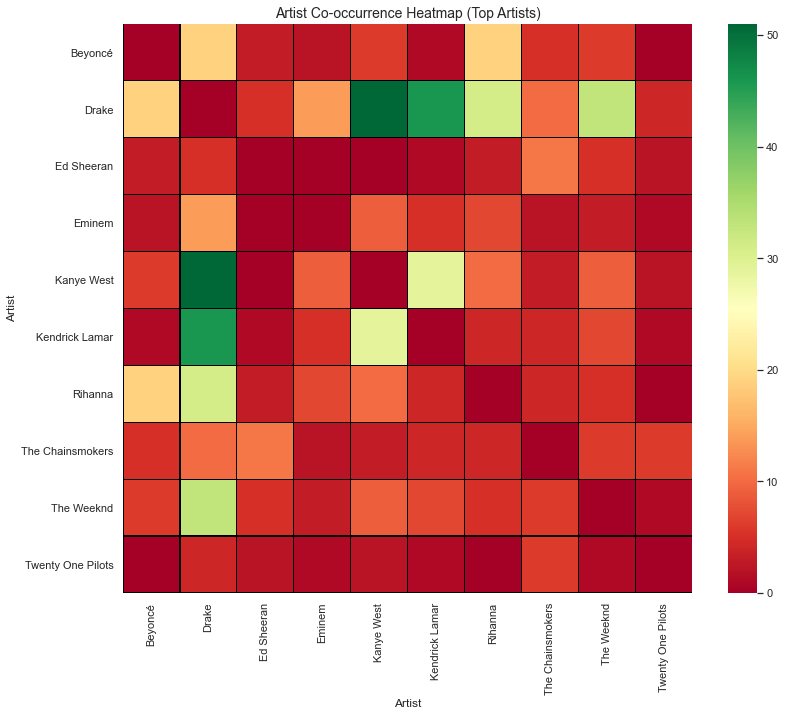

In [92]:
import seaborn as sns
import numpy as np


# Get top 10 artists by total co-occurrence
top_artists = pd.Series(df_artist_pairs["artist_a"]
                        .tolist() + df_artist_pairs["artist_b"].tolist()
                           ).value_counts().head(10).index.tolist()

# Filter to those pairs
mask = df_artist_pairs["artist_a"].isin(top_artists) & df_artist_pairs["artist_b"].isin(top_artists)
df_pairs_small = df_artist_pairs[mask]

# Build matrix
artists_sorted = sorted(top_artists)
matrix = pd.DataFrame(0, index=artists_sorted, columns=artists_sorted, dtype=int) 

for _, row in df_pairs_small.iterrows():
    a, b, w = row["artist_a"], row["artist_b"], row["num_playlists_together"]
    matrix.loc[a, b] = w #diagonal will stay 0 to not disrupt the outcome (we want to show significant co-occurences and not those created by construction)
    matrix.loc[b, a] = w

plt.figure(figsize=(12, 10))

sns.heatmap(
    matrix,
    cmap="RdYlGn",        
    linewidths=0.2,       # thin gridlines 
    linecolor="black",    # makes cells clearer
    square=True
)

plt.title("Artist Co-occurrence Heatmap (Top Artists)", fontsize=14)
plt.xlabel("Artist", fontsize=12)
plt.ylabel("Artist", fontsize=12)
plt.tight_layout()
plt.show()

In [77]:
# Merge top artists with playlist-level entropies
df_artist_playlists = (df_top_artists
    .merge(
        df_agg[["artist_entropy", "album_entropy"]],
        left_on="pid",
        right_index=True,
        how="left",
    )
)

# Aggregate per artist
df_artist_summary = (
    df_artist_playlists
    .groupby("artist_name")
    .agg(
        n_playlists=("pid", "nunique"),
        avg_rank=("rank_in_playlist", "mean"),
        avg_artist_entropy=("artist_entropy", "mean"),
        avg_album_entropy=("album_entropy", "mean"),
    )
    .sort_values("n_playlists", ascending=False)
)


In [87]:
df_artist_summary

,n_playlists,avg_rank,avg_artist_entropy,avg_album_entropy
artist_name,,,,
Drake,291,2.171821,0.919747,0.966249
Kanye West,130,2.853846,0.923013,0.968436
Kendrick Lamar,116,2.775862,0.922390,0.967590
Rihanna,106,2.839623,0.936865,0.978947
Ed Sheeran,100,2.590000,0.934863,0.971220
...,...,...,...,...
Jerry Garcia Band,1,1.000000,0.984665,0.992241
Jerry Purpdrank,1,4.000000,1.000000,1.000000
Jerry Yan,1,4.000000,0.959282,0.995620


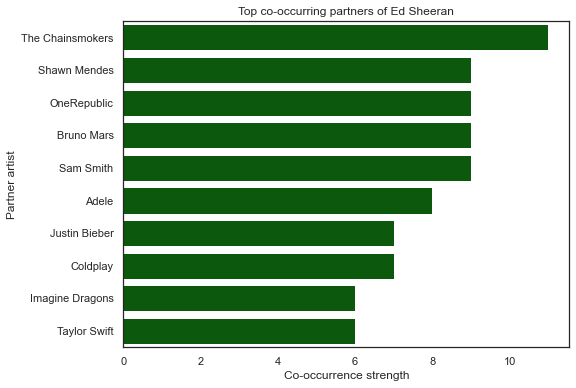

In [96]:
df_pairs_long = pd.concat([
    df_artist_pairs.rename(columns={"artist_a": "artist", "artist_b": "partner"}),
    df_artist_pairs.rename(columns={"artist_b": "artist", "artist_a": "partner"})
], ignore_index=True)

df_artist_co_stats = (
    df_pairs_long
    .groupby("artist")
    .agg(
        num_distinct_partners=("partner", "nunique"),
        total_pair_strength=("num_playlists_together", "sum"),
        strongest_single_pair=("num_playlists_together", "max")
    )
    .sort_values("total_pair_strength", ascending=False)
)


#Focus on specific artists
target_artist = "Ed Sheeran"   # example — replace with any artist name

df_drake_partners = (
    df_pairs_long
    .query("artist == @target_artist")
    .sort_values("num_playlists_together", ascending=False)
)

df_drake_partners.head()
plt.figure(figsize=(8,6))
sns.barplot(
    data=df_drake_partners.head(10),
    x="num_playlists_together",
    y="partner",
    color="darkgreen"
)
plt.title(f"Top co-occurring partners of {target_artist}")
plt.xlabel("Co-occurrence strength")
plt.ylabel("Partner artist")
plt.show()

# Question 3 - similarity

In [99]:
# ------------------------------------------------------------------
# Build a simple track feature table from df_full
# ------------------------------------------------------------------

# One row per unique track_uri with basic metadata
df_track_features = (
    df_full
    .dropna(subset=["track_uri"])
    .drop_duplicates(subset=["track_uri"])
    [["track_uri", "artist_uri", "album_uri", "duration_ms_track", "track_name", "artist_name", "album_name"]]
    .set_index("track_uri")
)


def _get_track_info(track_id: str):
    """
    Internal helper: return a row from df_track_features for a given track_uri.
    Raises KeyError if track not found.
    """
    return df_track_features.loc[track_id]


def simple_metadata_similarity(track_id_1: str,
                               track_id_2: str,
                               max_duration_diff_sec: float = 120.0) -> float:
    """
    Compute similarity between two tracks based only on metadata from the dataset.
    Returns a score between 0 and 1.

    Rules:
    - If track URIs are identical -> 1.0
    - Otherwise:
        S = 0.6 * same_artist
          + 0.2 * same_album
          + 0.2 * duration_closeness
    """
    # Same track -> maximum similarity
    if track_id_1 == track_id_2:
        return 1.0

    # Get metadata for both tracks
    try:
        t1 = _get_track_info(track_id_1)
        t2 = _get_track_info(track_id_2)
    except KeyError:
        # If one of the tracks is missing from df_track_features, return 0
        return 0.0

    # Same artist / same album (binary indicators)
    same_artist = 1.0 if t1["artist_uri"] == t2["artist_uri"] else 0.0
    same_album = 1.0 if t1["album_uri"] == t2["album_uri"] else 0.0

    # Duration closeness (in seconds)
    d1_sec = (t1["duration_ms_track"] or 0) / 1000.0
    d2_sec = (t2["duration_ms_track"] or 0) / 1000.0
    diff_sec = abs(d1_sec - d2_sec)

    # Map duration difference to [0,1]: 1 if identical length, goes to 0 after max_duration_diff_sec
    duration_closeness = 1.0 - min(diff_sec / max_duration_diff_sec, 1.0)

    # Weighted combination
    sim = 0.6 * same_artist + 0.2 * same_album + 0.2 * duration_closeness

    # Ensure bounds
    sim = float(max(0.0, min(1.0, sim)))
    return sim


In [106]:
# Build a small similarity matrix for the first 10 tracks
subset_tracks = df_track_features.index[:10].tolist()
sim_matrix = pd.DataFrame(index=subset_tracks, columns=subset_tracks, dtype=float)

for a in subset_tracks:
    for b in subset_tracks:
        sim_matrix.loc[a, b] = simple_metadata_similarity(a, b)
        
# ------- NEW CODE (replace URIs with readable labels) -------
labels = (df_track_features["track_name"] + " — " + df_track_features["artist_name"]).to_dict()
sim_matrix = sim_matrix.rename(index=labels, columns=labels)
        
sim_matrix.head()


,Lose Control (feat. Ciara & Fat Man Scoop) — Missy Elliott,Toxic — Britney Spears,Crazy In Love — Beyoncé,Rock Your Body — Justin Timberlake,It Wasn't Me — Shaggy,Yeah! — Usher,My Boo — Usher,Buttons — The Pussycat Dolls,Say My Name — Destiny's Child,Hey Ya! - Radio Mix / Club Mix — OutKast
Lose Control (feat. Ciara & Fat Man Scoop) — Missy Elliott,1.000000,0.153228,0.184883,0.132662,0.198772,0.160817,0.194295,0.197828,0.125883,0.186083
Toxic — Britney Spears,0.153228,1.000000,0.138112,0.085890,0.152000,0.114045,0.158933,0.155400,0.079112,0.139312
Crazy In Love — Beyoncé,0.184883,0.138112,1.000000,0.147778,0.186112,0.175933,0.179178,0.182712,0.141000,0.198800
Rock Your Body — Justin Timberlake,0.132662,0.085890,0.147778,1.000000,0.133890,0.171845,0.126957,0.130490,0.193222,0.146578
It Wasn't Me — Shaggy,0.198772,0.152000,0.186112,0.133890,1.000000,0.162045,0.193067,0.196600,0.127112,0.187312


In [107]:
#BELOW ON PAUSE FOR NOW - I NEED ACCESS TO THE SPOTIFY API

In [103]:
import requests

SPOTIFY_AUTH_URL = "https://accounts.spotify.com/api/token"
SPOTIFY_API_BASE = "https://api.spotify.com/v1/"


def get_spotify_token(client_id: str, client_secret: str) -> str:
    """Client Credentials flow: get a bearer token."""
    resp = requests.post(
        SPOTIFY_AUTH_URL,
        data={"grant_type": "client_credentials"},
        auth=(client_id, client_secret),
        timeout=10,
    )
    resp.raise_for_status()
    return resp.json()["access_token"]


def _extract_id_from_track_uri(uri: str) -> str:
    """
    Convert 'spotify:track:<id>' or 'https://open.spotify.com/track/<id>' into '<id>'.
    """
    if uri is None or not isinstance(uri, str):
        return None
    if uri.startswith("spotify:track:"):
        return uri.split(":")[-1]
    if "open.spotify.com/track" in uri:
        return uri.rstrip("/").split("/")[-1].split("?")[0]
    return uri  # fallback


def get_audio_features_for_tracks(track_ids: list, token: str) -> dict:
    """
    Fetch audio features for a list of Spotify track IDs.
    Returns: dict[track_id] = audio_features_json
    """
    headers = {"Authorization": f"Bearer {token}"}
    features_map = {}

    # API accepts up to 100 ids per call
    for i in range(0, len(track_ids), 100):
        batch = track_ids[i:i+100]
        ids_param = ",".join(batch)
        url = SPOTIFY_API_BASE + "audio-features"
        resp = requests.get(url, headers=headers, params={"ids": ids_param}, timeout=10)
        resp.raise_for_status()
        data = resp.json()
        for item in data.get("audio_features", []):
            if item is None:
                continue
            features_map[item["id"]] = item

    return features_map


In [ ]:
#Other solution

In [108]:
from itertools import product
import numpy as np

def jaccard(set1, set2):
    if len(set1) == 0 and len(set2) == 0:
        return 0
    return len(set1 & set2) / len(set1 | set2)


def playlist_similarity(pid1, pid2, 
                        df_full=df_full,
                        sample_size=15):
    """
    Compute similarity between two playlists.
    Uses three components:
    - Track Jaccard
    - Artist Jaccard
    - Average cross-track similarity (sampled)
    """

    # Extract sets
    t1 = set(df_full[df_full["pid"] == pid1]["track_uri"].dropna())
    t2 = set(df_full[df_full["pid"] == pid2]["track_uri"].dropna())

    a1 = set(df_full[df_full["pid"] == pid1]["artist_uri"].dropna())
    a2 = set(df_full[df_full["pid"] == pid2]["artist_uri"].dropna())

    # Track & artist Jaccard
    s_tracks = jaccard(t1, t2)
    s_artists = jaccard(a1, a2)

    # Cross-track similarity (sample to reduce cost)
    if len(t1) > sample_size:
        t1_sample = np.random.choice(list(t1), sample_size, replace=False)
    else:
        t1_sample = list(t1)

    if len(t2) > sample_size:
        t2_sample = np.random.choice(list(t2), sample_size, replace=False)
    else:
        t2_sample = list(t2)

    sims = [
        simple_metadata_similarity(x, y)
        for x, y in product(t1_sample, t2_sample)
    ]

    s_cross = float(np.mean(sims)) if sims else 0.0

    # Weighted final score
    S = 0.5 * s_tracks + 0.3 * s_artists + 0.2 * s_cross
    return float(S)


In [110]:
p1, p2, p3 = df_agg.index[:3]  
print(playlist_similarity(p1, p2))
print(playlist_similarity(p1, p3))
print(playlist_similarity(p2, p3))

0.007673795555555557
0.031568626666666676
0.01524764148148148


In [112]:
target_pid = df_agg.index[0]   # choose first playlist


most_similar = sorted(
    [(pid_other, playlist_similarity(target_pid, pid_other))
     for pid_other in df_agg.index if pid_other != target_pid],
    key=lambda x: x[1],
    reverse=True
)[:20]

In [114]:
most_similar

[(10376, 0.15908256190286593),
 (262, 0.15824162443270418),
 (1247, 0.146302512617619),
 (1546, 0.13710024915849223),
 (1658, 0.13479196740740743),
 (1174, 0.13422889217391304),
 (10460, 0.13176818560427472),
 (10742, 0.12959039597130728),
 (717, 0.12946023528344672),
 (747, 0.1287017570245876),
 (1625, 0.12392579304347826),
 (38, 0.12347957176470589),
 (908, 0.11983832773442939),
 (355, 0.11923420952380953),
 (10888, 0.11683884577540107),
 (721, 0.1162689206247211),
 (10717, 0.11544158201058201),
 (944, 0.11384927017543861),
 (10933, 0.11365657734204794),
 (10935, 0.11181996525252526)]